In [1]:
import copy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import glob
import os
from sklearn import preprocessing
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
# get feature values for all flows from all packet capture and remove missing values due to inconsistent timestamp
# if the number of samples (consectutive timestamp) between two missing values is greater than 11, keep it as an individual dataset
# in the most extreme case, the last sample of the 11 will be used as output for either testing or training 
# and the previous 10 samples (5s) will be used to as features
# time aggregation is 500ms

# all files from both Webex and Webrtc
files = glob.glob("Retina/shared/*/*/*_500ms_Song_no_log.csv")

scaler = preprocessing.MinMaxScaler() # for normalization

# get all of the individual flows from all csv files
df_total = []
for file in files:   
    df_input = pd.read_csv(file)
    
    # made a copy just in case, only keep those with receiver being ourselves, drop useless columns
    df_inter = copy.deepcopy(df_input)
    df_inter = df_inter.loc[~df_inter['ip_src'].str.startswith('192')]
    drop_col = [
        'software', 
        'label', 
        'pcap', 
        'ssrc', 
        'rtp_seq_num_packet_loss', 
        'ip_src', 
        'ip_dst', 
        'prt_src', 
        'prt_dst', 
        'rtp_csrc_csrc_agg',
        'p_type'
    ]
    for col in df_inter.columns:
        if col in drop_col or col.startswith('rtp_interarrival'): # maybe also for 'rtp_inter'
            df_inter.drop(col, axis=1, inplace=True)
    
    # break down into individual flows
    flow_list = df_inter['flow'].drop_duplicates().tolist()
    for flow in flow_list:
        df_check = df_inter[df_inter['flow'] == flow].copy()
        if df_check.shape[0] > 11: 
            df_total.append(df_check)

# for each individual flow, deal with potential missing values            
df_total_final = []
for df_per_flow in df_total:
    df_temp = copy.deepcopy(df_per_flow)
    df_temp.reset_index(inplace=True)
    df_temp['lossOrNot'] = [1 if x>0 else 0 for x in df_temp['num_packet_loss']] # we only need the presence condition of packet loss
    df_temp.drop(['num_packet_loss', 'index', 'flow'], axis=1, inplace=True)
    
    # normalization
    for col in df_temp.columns:
        if col not in ['timestamp', 'lossOrNot']:
            df_temp[col] = scaler.fit_transform(df_temp[col].values.reshape(-1,1))
    
    # get the beginning and ending timestamp to check whether there's missing value or not and build the complete df
    start_time = pd.to_datetime(df_temp['timestamp'].min())
    stop_time = pd.to_datetime(df_temp['timestamp'].max())
    timestamp_ser = pd.date_range(start_time, stop_time, freq="500L")
    correct_len = len(timestamp_ser)
    
    # if there is no missing values, just add it to the list
    if df_temp.shape[0] == correct_len:
        df_full = copy.deepcopy(df_temp)
        df_total_final.append(df_full)
    
    # if there is at least one missing value, break down the whole flow and add those with length >= 11 to the list
    else:
        # merge df without missing value and df with missing value
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
        df_full = pd.DataFrame({'timestamp': timestamp_ser})
        df_full['timestamp'] = df_full['timestamp']
        df_full = df_full.merge(df_temp, on='timestamp', how='left')
        
        # missing values will result in 'nan' for all columns and find these row(index)
        nan_index_list = [0]
        nan_index_list.extend(df_full[np.isnan(df_full['interarrival_std'])].index.tolist())
        nan_index_list.append(df_full.index[-1])
        
        # check the distance between each missing value (index) and keep those >= 11 in between 
        for i in range(1, len(nan_index_list)):
            if nan_index_list[i] - nan_index_list[i-1] - 1 >= 11:
                start_idx = 0 if nan_index_list[i-1]==0 else nan_index_list[i-1]+1
                stop_idx = df_full.index[-1]+1 if nan_index_list[i]==df_full.index[-1] else nan_index_list[i]
                df_separate = df_full.iloc[start_idx:stop_idx, :].copy()
                df_separate.reset_index(inplace=True)
                df_separate.drop(['index'], axis=1, inplace=True)
                df_total_final.append(df_separate)

In [3]:
# this is the features selected based on the trending visualized in plots

initial_selected_features_list_based_on_visualization = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_diff',
    'interarrival_max_min_R',
    'interarrival_min_max_R',
    'interarrival_max_value_count_percent',
    'len_udp_std',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std',
    'inter_time_sequence_max_min_diff'
]

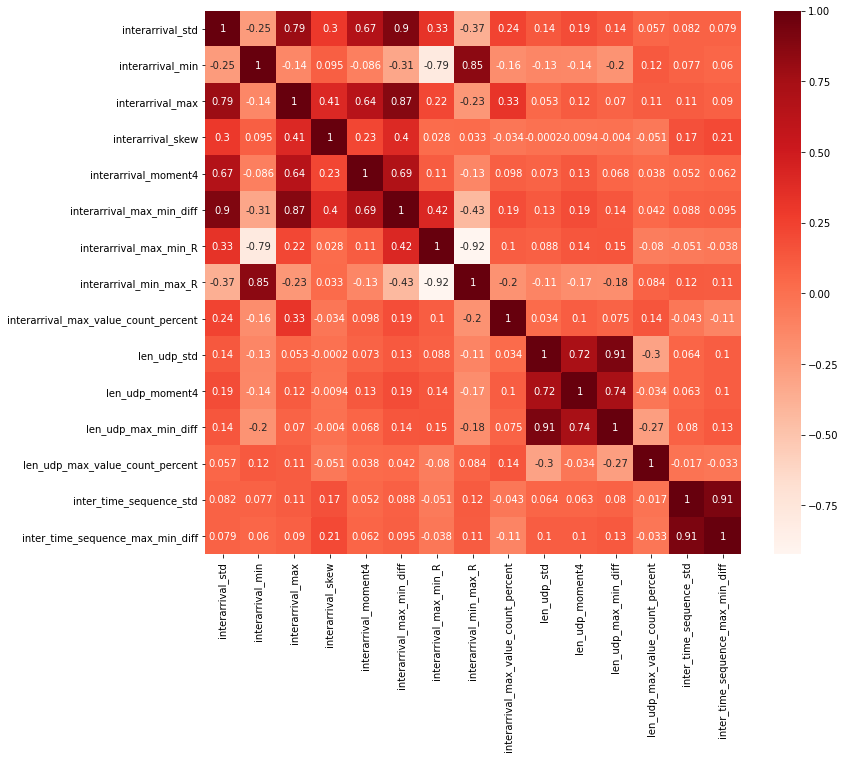

In [4]:
# connect all individual dfs and calculate the correlations among selected features

df_one_for_all = pd.concat(df_total_final)
df_temp = copy.deepcopy(df_one_for_all)
df_temp = df_temp[initial_selected_features_list_based_on_visualization]
plt.figure(figsize=(12,10))
cor = df_temp.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [18]:
# remove those with correlation >= 0.9

complete_list = ['timestamp', 'lossOrNot']
selected_features_list_removing_correlation = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'interarrival_max_value_count_percent',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]
complete_list.extend(selected_features_list_removing_correlation)

full_features_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1,11):
        col_title = f'{feature}_minus_{500*i}ms'
        full_features_list.append(col_title)

In [6]:
# based on the features selected before, create the columns based on previous values (in past 5s, 10 samples)
# get rid of the first 10 lines 

group_id = 1
df_total_final_feature_extraction = []
for df in df_total_final:
    df_temp = copy.deepcopy(df)
    df_temp = df_temp[complete_list]
    df_temp['group_id'] = group_id
    group_id += 1
    for feature in selected_features_list_removing_correlation:
        for i in range(1,11):
            col_title = f'{feature}_minus_{500*i}ms'
            df_temp[col_title] = df_temp[feature].shift(periods=i, fill_value=-1)
    df_temp.drop(selected_features_list_removing_correlation, axis=1, inplace=True)
    df_temp = df_temp.iloc[10:]
    df_temp.reset_index(inplace=True)
    df_temp.drop(['index'], axis=1, inplace=True)
    
    df_total_final_feature_extraction.append(df_temp)

In [7]:
df_complete_with_features_final = pd.concat(df_total_final_feature_extraction)
df_complete_with_features_final.reset_index(inplace=True)
df_complete_with_features_final.drop(['index'], axis=1, inplace=True)

In [8]:
df_complete_with_features_final

,timestamp,lossOrNot,group_id,interarrival_std(-500ms),interarrival_std(-1000ms),interarrival_std(-1500ms),interarrival_std(-2000ms),interarrival_std(-2500ms),interarrival_std(-3000ms),interarrival_std(-3500ms),...,inter_time_sequence_std(-500ms),inter_time_sequence_std(-1000ms),inter_time_sequence_std(-1500ms),inter_time_sequence_std(-2000ms),inter_time_sequence_std(-2500ms),inter_time_sequence_std(-3000ms),inter_time_sequence_std(-3500ms),inter_time_sequence_std(-4000ms),inter_time_sequence_std(-4500ms),inter_time_sequence_std(-5000ms)
0,2020-12-14 13:34:44.500000,0.0,1,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,0.584144,...,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312,0.000000
1,2020-12-14 13:34:45,0.0,1,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,...,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312
2,2020-12-14 13:34:45.500000,0.0,1,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,...,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376
3,2020-12-14 13:34:46,0.0,1,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,...,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850
4,2020-12-14 13:34:46.500000,0.0,1,0.113890,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,...,0.210085,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028655,2020-05-13 14:59:09.000,0.0,6998,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,0.069150,...,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018,0.934599
2028656,2020-05-13 14:59:09.500,0.0,6998,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,...,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018
2028657,2020-05-13 14:59:10.000,0.0,6998,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,...,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018
2028658,2020-05-13 14:59:10.500,0.0,6998,0.133611,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,...,0.223662,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054


In [9]:
count_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] > 0]['lossOrNot'].count()
count_no_loss = df_complete_with_features_final.shape[0] - count_loss

In [10]:
f"{format(count_loss / count_no_loss * 100, '.3f')}%"

'1.410%'

In [11]:
df_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] > 0]
df_no_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] < 1]

In [12]:
df_loss_shuffled = df_loss.sample(frac=1).reset_index()
df_loss_shuffled.drop(['index'], axis=1, inplace=True)
df_no_loss_shuffled = df_no_loss.sample(frac=1).reset_index()
df_no_loss_shuffled.drop(['index'], axis=1, inplace=True)

In [84]:
df_loss_shuffled

,timestamp,lossOrNot,group_id,interarrival_std(-500ms),interarrival_std(-1000ms),interarrival_std(-1500ms),interarrival_std(-2000ms),interarrival_std(-2500ms),interarrival_std(-3000ms),interarrival_std(-3500ms),...,inter_time_sequence_std(-500ms),inter_time_sequence_std(-1000ms),inter_time_sequence_std(-1500ms),inter_time_sequence_std(-2000ms),inter_time_sequence_std(-2500ms),inter_time_sequence_std(-3000ms),inter_time_sequence_std(-3500ms),inter_time_sequence_std(-4000ms),inter_time_sequence_std(-4500ms),inter_time_sequence_std(-5000ms)
0,2021-01-11 15:40:49.500000,1.0,1574,0.074984,0.105139,0.057315,0.072987,0.058925,0.054081,0.061632,...,0.581114,0.200547,0.653820,0.110357,0.160162,0.590397,0.234914,0.072722,0.689497,0.152427
1,2021-01-11 15:34:18.500000,1.0,1745,0.065267,0.105375,0.077558,0.161942,0.128387,0.085485,0.096842,...,0.224744,0.583300,0.155096,0.116396,0.771262,0.201529,0.570113,0.054451,0.113805,0.178313
2,2020-12-10 13:41:59.500000,1.0,754,0.151609,0.147218,0.134779,0.145042,0.121783,0.146350,0.130079,...,0.412674,0.454833,0.233323,0.328035,0.467972,0.219703,0.222294,0.481059,0.301881,0.195944
3,2021-01-11 14:51:57,1.0,1555,0.032564,0.031001,0.017363,0.028875,0.045207,0.020353,0.046660,...,0.483870,0.147980,0.141824,0.602946,0.141824,0.135669,0.554789,0.141824,0.262703,0.135669
4,2020-05-16 15:30:51.500000,1.0,5905,0.079339,0.031700,0.089291,0.087067,0.191270,0.100011,0.223725,...,0.205517,0.473574,0.223994,0.629412,0.138132,0.131852,0.123203,0.058092,0.071399,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28202,2021-01-11 15:27:50,1.0,1759,0.027933,0.020404,0.021684,0.035011,0.050093,0.060255,0.048765,...,0.178313,0.750528,0.201529,0.155096,0.583762,0.178313,0.673097,0.148282,0.186052,0.734887
28203,2020-05-07 13:52:47.500000,1.0,3916,0.169729,0.173287,0.157145,0.148713,0.062825,0.081640,0.079730,...,0.354799,0.761761,0.713792,0.330524,0.664505,0.635912,0.388294,0.633200,0.683849,0.336814
28204,2021-01-11 15:41:17,1.0,1767,0.046872,0.030222,0.051893,0.044651,0.103845,0.066211,0.047001,...,0.162835,0.725137,0.162835,0.224744,0.747678,0.124137,0.193790,0.336747,0.145903,0.673719
28205,2020-05-12 14:15:39.500000,1.0,2947,0.154371,0.072134,0.090258,0.109265,0.080270,0.116284,0.100089,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [85]:
df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_no_loss_shuffled.shape[0] * 0.7)]])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_no_loss_shuffled.shape[0] * 0.7)+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

In [47]:
# the following is for test

# df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.05)], df_no_loss_shuffled.iloc[0:int(df_no_loss_shuffled.shape[0] * 0.05)]])
# df_train_shuffled = df_train.sample(frac=1).reset_index()
# df_train_shuffled.drop(['index'], axis=1, inplace=True)
# df_test = pd.concat([
#     df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.1)+1: int(df_loss_shuffled.shape[0] * 0.15)], 
#     df_no_loss_shuffled.iloc[int(df_no_loss_shuffled.shape[0] * 0.1)+1: int(df_no_loss_shuffled.shape[0] * 0.15)]
# ])
# df_test_shuffled = df_test.sample(frac=1).reset_index()
# df_test_shuffled.drop(['index'], axis=1, inplace=True)

In [86]:
x_train = df_train_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

In [40]:
from sklearn.tree import DecisionTreeClassifier#for checking testing results
from sklearn.metrics import classification_report, confusion_matrix#for visualizing tree 
from sklearn.tree import plot_tree

In [91]:
my_tree = DecisionTreeClassifier()
my_tree.fit(x_train, y_train)

DecisionTreeClassifier()

In [92]:
y_pred = my_tree.predict(x_test)
print("Prediction Report\n", classification_report(y_test, y_pred))

Prediction Report
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    600134
           1       0.10      0.14      0.12      8461

    accuracy                           0.97    608595
   macro avg       0.55      0.56      0.55    608595
weighted avg       0.98      0.97      0.97    608595



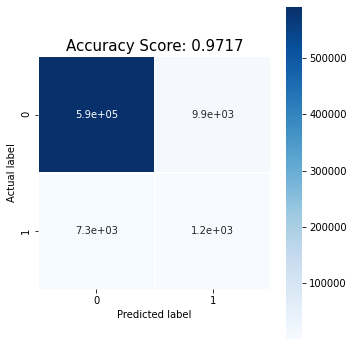

In [93]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f"Accuracy Score: {format(my_tree.score(x_test, y_test), '.4f')}"
plt.title(all_sample_title, size = 15)
plt.tight_layout()
plt.show()

In [117]:
group_id = 1
df_total_final_feature_extraction_plus = []
for df in df_total_final:
    df_temp = copy.deepcopy(df)
    df_temp = df_temp[complete_list]
    df_temp['group_id'] = group_id
    group_id += 1
    for feature in selected_features_list_removing_correlation:
        for i in range(1,11):
            col_title = f'{feature}(-{500*i}ms)'
            df_temp[col_title] = df_temp[feature].shift(periods=i, fill_value=-1)
    df_temp.drop(selected_features_list_removing_correlation, axis=1, inplace=True)
    df_temp = df_temp.iloc[10:]
    df_temp.reset_index(inplace=True)
    df_temp.drop(['index'], axis=1, inplace=True)
    
    df_temp['lossOrNotPlus'] = df_temp['lossOrNot']
    df_temp['lossOrNotPlus'] = df_temp['lossOrNotPlus'].rolling(min_periods=1, window=11).sum() - df_temp['lossOrNotPlus']
    conditions = [df_temp['lossOrNotPlus'].gt(0) & df_temp['lossOrNot'].gt(0)]
    choices = [2]
    df_temp['lossOrNotPlus'] = np.select(conditions, choices, default=df_temp['lossOrNot'])
    
    df_total_final_feature_extraction_plus.append(df_temp)

In [118]:
df_complete_with_features_final_plus = pd.concat(df_total_final_feature_extraction_plus)
df_complete_with_features_final_plus.reset_index(inplace=True)
df_complete_with_features_final_plus.drop(['index'], axis=1, inplace=True)

In [119]:
df_sparse_loss = df_complete_with_features_final_plus[df_complete_with_features_final_plus['lossOrNotPlus'] == 1]
df_concentrated_loss = df_complete_with_features_final_plus[df_complete_with_features_final_plus['lossOrNotPlus'] == 2]
df_no_loss = df_complete_with_features_final_plus[df_complete_with_features_final_plus['lossOrNotPlus'] == 0]

In [124]:
df_sparse_loss_shuffled = df_sparse_loss.sample(frac=1).reset_index()
df_sparse_loss_shuffled.drop(['index'], axis=1, inplace=True)
df_concentrated_loss_shuffled = df_concentrated_loss.sample(frac=1).reset_index()
df_concentrated_loss_shuffled.drop(['index'], axis=1, inplace=True)
df_no_loss_shuffled = df_no_loss.sample(frac=1).reset_index()
df_no_loss_shuffled.drop(['index'], axis=1, inplace=True)

df_train = pd.concat([
    df_sparse_loss_shuffled.iloc[0:int(df_sparse_loss_shuffled.shape[0] * 0.7)], 
    df_concentrated_loss_shuffled.iloc[0:int(df_concentrated_loss_shuffled.shape[0] * 0.7)], 
    df_no_loss_shuffled.iloc[0:int(df_no_loss_shuffled.shape[0] * 0.7)]
])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test = pd.concat([
    df_sparse_loss_shuffled.iloc[int(df_sparse_loss_shuffled.shape[0] * 0.7)+1: -1], 
    df_concentrated_loss_shuffled.iloc[int(df_concentrated_loss_shuffled.shape[0] * 0.7)+1: -1], 
    df_no_loss_shuffled.iloc[int(df_no_loss_shuffled.shape[0] * 0.7)+1: -1]
])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

x_train = df_train_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNotPlus']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNotPlus']]
y_test = y_test.astype(int)

In [125]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)

DecisionTreeClassifier()

In [126]:
y_pred = dtree.predict(x_test)
print("Prediction Report\n", classification_report(y_test, y_pred))

Prediction Report
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    600134
           1       0.02      0.03      0.02      3219
           2       0.14      0.18      0.16      5240

    accuracy                           0.97    608593
   macro avg       0.38      0.40      0.39    608593
weighted avg       0.98      0.97      0.97    608593



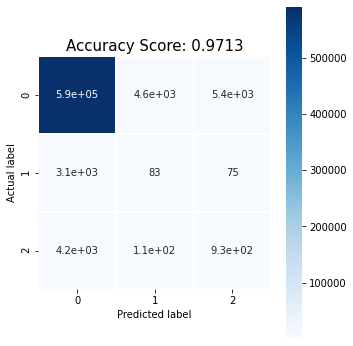

In [127]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f"Accuracy Score: {format(dtree.score(x_test, y_test), '.4f')}"
plt.title(all_sample_title, size = 15)
plt.tight_layout()
plt.show()